<a href="https://colab.research.google.com/github/theol0403/APSC100-Mod3-727C/blob/main/APSC100_Mod3_727C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup and MNIST Demo



Import needed python libraries and set up matplotlib

In [ ]:
# import libraries
import os
import numpy as np
import pandas as pd
import ipywidgets as widgets

# imports for scikit/knn
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import svm, metrics
from joblib import dump, load

# import keras classes
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set up matplotlib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.autolayout"] = True
plt.inferno()

# load mnist into 4 arrays
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# scale down the pixel values to [0, 1] instead of [0, 255]
train_x = train_x / 255.0
test_x = test_x / 255.0

# print original data shape
print('Original train shape: {}'.format(train_x.shape))
print('Original test shape: {}'.format(test_x.shape))

# changing train_x from (70000, 28, 28) into a 2d array of (70000, 28*28)
train_x_flat = train_x.reshape(train_x.shape[0], 28*28)
test_x_flat = test_x.reshape(test_x.shape[0], 28*28)

# create a "one-hot" vector that converts the labels into a binary mask
# 4 will be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# 9 will be [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
train_y_hot = to_categorical(train_y)
test_y_hot = to_categorical(test_y)


11501568/11490434 [==============================] - 0s 0us/step
Original train shape: (60000, 28, 28)
Original test shape: (10000, 28, 28)


<Figure size 432x288 with 0 Axes>

Show images

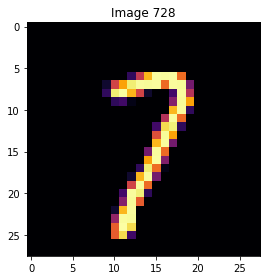

In [ ]:
image = 728
plt.imshow(train_x[image])
plt.title(f"Image {image}")
plt.show()

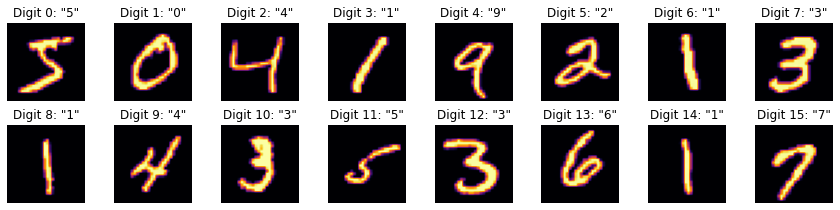

In [ ]:
# configure plot
rows = 2
cols = 8
offset = 0

# make a matplotlib subplot grid
fig, axes = plt.subplots(rows, cols,figsize=(1.5*cols,1.5*rows))
# this is how you loop through a 2d array in a single loop while knowing index
for i, ax in enumerate(axes.flat): 
    ax.imshow(train_x[i+offset])
    ax.set_title(f'Digit {i+offset}: "{train_y[i+offset]}"')
    ax.axis(False)
plt.show()

# Data Augmentation

In [ ]:
#@title Data Augmentation { run: "auto", form-width: "40%" }
augment_data = True #@param {type:"boolean"}

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        shear_range = 20, # Randomly shear image 
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

generator = datagen.flow(train_x.reshape(-1,28,28,1), train_y, batch_size=128)

datagen_weak = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        shear_range = 10, # Randomly shear image 
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

if augment_data:
  generated = next(datagen.flow(train_x.reshape(-1,28,28,1), train_y, batch_size=train_x.shape[0]*2))
  train_x_aug = generated[0]
  train_y_aug = generated[1]
  train_x_aug_flat = np.reshape(train_x_aug, (train_x_aug.shape[0], 28*28))

# Keras Models

In [ ]:
#@title Keras Models { run: "auto", form-width: "40%" }
compile_model = True #@param {type:"boolean"}
model_type = "CNN" #@param ["MLP", "MLP_Dropout", "CNN"]

# set up model
model = Sequential()

if model_type == 'MLP':
  # take the 2D array of 28x28 and convert to 1D array of 28*28=784
  model.add(Flatten(input_shape=(28,28,1))) 
  model.add(Dense(32, activation="relu"))
  model.add(Dense(16, activation="relu"))
  model.add(Dense(10, activation="softmax"))
elif model_type == 'MLP_Dropout':
  model.add(Flatten(input_shape=(28,28,1))) 
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.45))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.45))
  model.add(Dense(10, activation='softmax'))
elif model_type == 'CNN':
  model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
  model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
  model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())    
  model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
      
  model.add(MaxPooling2D(pool_size=(2,2)))
      
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(512,activation="relu"))
      
  model.add(Dense(10,activation="softmax"))
  
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# summary
summary = widgets.Output()
with summary: model.summary()

summary_plot = widgets.Output()
with summary_plot:
  plot = plot_model(model, show_shapes=True, show_layer_activations=True, dpi=60)
  display(plot)

display(widgets.Box([summary, summary_plot]))

Box(children=(Output(), Output()))

Epoch 1/30
469/469 [==============================] - 37s 75ms/step - loss: 0.2986 - accuracy: 0.9052 - val_loss: 0.1983 - val_accuracy: 0.9355
Epoch 2/30
469/469 [==============================] - 29s 62ms/step - loss: 0.1197 - accuracy: 0.9634 - val_loss: 0.2364 - val_accuracy: 0.9240
Epoch 3/30
469/469 [==============================] - 28s 60ms/step - loss: 0.0984 - accuracy: 0.9693 - val_loss: 0.0495 - val_accuracy: 0.9841
Epoch 4/30
469/469 [==============================] - 28s 59ms/step - loss: 0.0809 - accuracy: 0.9747 - val_loss: 0.0624 - val_accuracy: 0.9818
Epoch 5/30
469/469 [==============================] - 29s 61ms/step - loss: 0.0760 - accuracy: 0.9771 - val_loss: 0.0727 - val_accuracy: 0.9770
Epoch 6/30
469/469 [==============================] - 28s 59ms/step - loss: 0.0708 - accuracy: 0.9786 - val_loss: 0.0368 - val_accuracy: 0.9893
Epoch 7/30
469/469 [==============================] - 28s 59ms/step - loss: 0.0660 - accuracy: 0.9795 - val_loss: 0.0599 - val_accuracy:

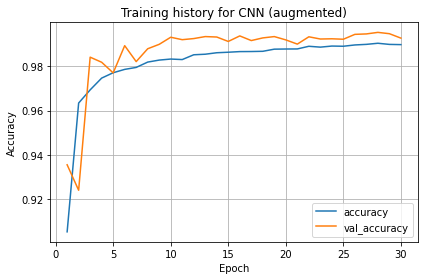

In [ ]:
if compile_model:
  # train model
  if augment_data:
    history = model.fit(generator, epochs=30, batch_size=128, validation_data=(test_x, test_y))
  else:
    history = model.fit(train_x, train_y, epochs=10, batch_size=128, validation_data=(test_x, test_y))

  # save model
  model.save(f"{model_type}"+ ("_augmented" if augment_data else "") +".h5")

  # evalulate model 
  accuracy = history.history['val_accuracy']
  max_acc_epoch = np.argmax(accuracy) + 1
  max_acc = max(accuracy) * 100
  print(f'Max accuracy at epoch {max_acc_epoch} = {max_acc:.3f}%')

  plt.plot(range(1, len(accuracy)+1), history.history['accuracy'], label='accuracy')
  plt.plot(range(1, len(accuracy)+1), accuracy, label='val_accuracy')
  plt.title(f"Training history for {model_type}" + (" (augmented)" if augment_data else ""))
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid()
  plt.savefig(f"{model_type}_history"+("_aug" if augment_data else ""), dpi=300)
  plt.show()

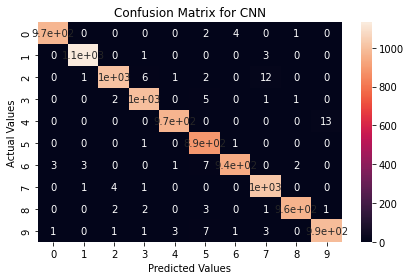

In [ ]:
if compile_model:
  # confusion matrix
  pred_y = model.predict(test_x).argmax(axis=1)
  cf_matrix = confusion_matrix(test_y, pred_y, labels=range(10))
  ax = sns.heatmap(cf_matrix, annot=True)
  plt.title(f"Confusion Matrix for {model_type}"+ (" (augmented)" if augment_data else ""))
  plt.xlabel("Predicted Values")
  plt.ylabel("Actual Values")
  plt.savefig(f"{model_type}_cf"+("_aug" if augment_data else ""), dpi=300)
  plt.show()

# KNN

In [ ]:
find_k = False #@param {type:"boolean"}
if find_k:

  # finding best k value
  best = (0, 0)
  accs = []
  for i in range(1, 11) :
    knn = KNeighborsClassifier(i, n_jobs=-1,weights='distance')
    if augment_data:
      knn.fit(train_x_aug_flat, train_y_aug)
    else:
      knn.fit(train_x_flat, train_y)
  
    predicted = knn.predict(test_x_flat[:1000])
    acc = accuracy_score(test_y[:1000], predicted)
    print(f"k = {i}, acc = {acc}")
    accs.append(acc)
    if acc > best[0]:
      best = (acc, i)
  
  print(f"best = {best}")
  
  plt.plot(range(1,11), accs)
  plt.xticks(range(1,11))
  plt.title("Accuracy vs K value"+ (" (augmented)" if augment_data else ""))
  plt.xlabel('K value')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.savefig(f"knn_accvsk"+("_aug" if augment_data else ""), dpi=300)
  plt.show()

In [ ]:
# find full accuracy
find_full_k = True #@param {type:"boolean"}
if find_full_k:

  if augment_data:
    knn = KNeighborsClassifier(6, weights='distance')
  else:
    knn = KNeighborsClassifier(3, weights='distance')

  if augment_data:
    knn.fit(train_x_aug_flat, train_y_aug)
  else:
    knn.fit(train_x_flat, train_y)
  
  # dump(knn, 'knn' +("_augmented" if augment_data else "")+ '.joblib') 

  # predicted = knn.predict(test_x_flat)
  # acc = accuracy_score(test_y, predicted)
  # print("{:.1f}".format(acc*100),"%")

  # cf_matrix = confusion_matrix(test_y, predicted, labels=range(10))
  # ax = sns.heatmap(cf_matrix, annot=True)
  # plt.title("Confusion Matrix for KNN"+ (" (augmented)" if augment_data else ""))
  # plt.xlabel("Predicted Values")
  # plt.ylabel("Actual Values")
  # plt.savefig(f"KNN_cf"+("_aug" if augment_data else ""), dpi=300)
  # plt.show()

# SVM

93.7 %


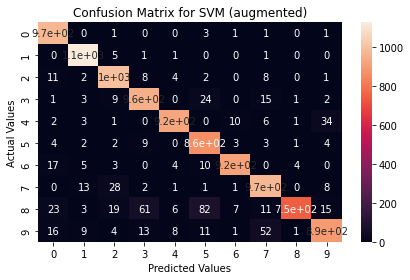

In [ ]:
find_svm = True #@param {type:"boolean"}

if find_svm:
  svc = svm.SVC(C=2)
  
  if augment_data:
    svc.fit(train_x_aug_flat[:120000], train_y_aug[:120000])
  else:
    svc.fit(train_x_flat, train_y)

  dump(svc, 'svm' +("_augmented" if augment_data else "")+ '.joblib') 

  predict = svc.predict(test_x_flat)
  acc = accuracy_score(test_y, predict)
  print("{:.1f}".format(acc*100),"%")

  cf_matrix = confusion_matrix(test_y, predict, labels=range(10))
  ax = sns.heatmap(cf_matrix, annot=True)
  plt.title("Confusion Matrix for SVM"+ (" (augmented)" if augment_data else ""))
  plt.xlabel("Predicted Values")
  plt.ylabel("Actual Values")
  plt.savefig(f"SVM_cf"+("_aug" if augment_data else ""), dpi=300)
  plt.show()